# 1. Slug Test - Pratt County

### Import packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import timflow.transient as tft

plt.rcParams['figure.figsize'] = [5, 3]

### Introduction and Conceptual Model

This slug test, taken from AQTESOLV examples (Duffield, 2007), was conducted in Pratt County Monitoring Site, US, and reported by Butler (1998). 

A partially penetrating well is screened in unconsolidated alluvial deposits, consisting of sand and gravel interbedded by clay. The total thickness of the aquifer is 47.87 m. The screen is located at 16.77 m depth and has a screen length 1.52 m the well radius is 0.125 m, and the casing radius 0.064 m. The slug displacement is 0.671 m. Head change has been recorded at the slug well.

<img src="./figs/Pratt_County.png" style="width:400pt">

### Load data

In [15]:
data = np.loadtxt("data/slug.txt", skiprows=1)
to = data[:, 0] / 60 / 60 / 24  # convert time in seconds to days
ho = data[:, 1] #m 

### Parameters and model

In [18]:
rw = 0.125  # well radius in m
rc = 0.064  # well casing radius in m
L = 1.52  # screen length in m
b = -47.87  # aquifer thickness in m
zt = -16.77  # depth to top of screen in m
H0 = 0.671  # initial displacement in the well in m
zb = zt - L  # bottom of screen in m

The input for the slug test in `timflow` is the added or removed volume. Therefore, we must first convert our measured displacement into volume.

In [22]:
Q = np.pi * rc**2 * H0
print("slug:", round(Q, 5), "m^3")

slug: 0.00863 m^3


We conceptualize the aquifer as a three-layer model, one layer above the screen, one layer at the screen top and bottom and another layer just below it.

The setting of the slug well is slightly different from the pumping well. We detail the differences below:
* the ```tsandQ``` argument in the ```Well``` object has a different meaning. Instead of meaning the time of start or shutdown and the pumping rate of the pumping well, it means the time a volume is instantaneously added or removed from the well. In our case, we defined it as ```[(0, -Q)]``` where ```0``` is the moment in time when we added the slug and ```Q``` is the added volume. A negative sign means a volume is added. Otherwise, it would mean an extracted volume.
* the ```wbstype``` argument is set to ```' slug'```, so `timflow` knows the ```tsandQ``` argument means time and instant volumes, instead of pumping rates.

In [24]:
ml = tft.Model3D(kaq=10, z=[0, zt, zb, b], Saq=1e-4, kzoverkh=1, tmin=1e-6, tmax=0.01)
w = tft.Well(ml, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, -Q)], layers=1, wbstype="slug")
ml.solve()

self.neq  1
solution complete


### Estimate aquifer parameters 

In [26]:
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq", layers=[0, 1, 2], initial=10)
cal.set_parameter(name="Saq", layers=[0, 1, 2], initial=1e-4)
cal.seriesinwell(name="obs", element=w, t=to, h=ho)
cal.fit(report=True)

.......................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 61
    # variables        = 2
    chi-square         = 4.9800e-04
    reduced chi-square = 8.4407e-06
    Akaike info crit   = -710.662504
    Bayesian info crit = -706.440756
[[Variables]]
    kaq_0_2:  6.04867256 +/- 0.02486885 (0.41%) (init = 10)
    Saq_0_2:  2.1319e-04 +/- 1.0494e-05 (4.92%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq_0_2, Saq_0_2) = -0.6526


In [28]:
display(cal.parameters)
print("RMSE:", cal.rmse())

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_2,"[0, 1, 2]",6.048673,0.024869,0.411146,-inf,inf,10.0000,None,"[[6.048672558447974, 6.048672558447974, 6.0486..."
Saq_0_2,"[0, 1, 2]",0.000213,0.000010,4.922186,-inf,inf,0.0001,None,"[[0.00021318989015063131, 0.000213189890150631..."


RMSE: 0.002857267940528677


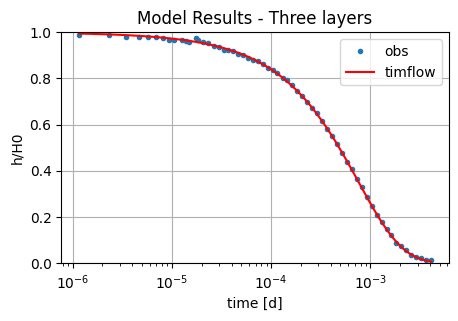

In [37]:
tm = np.logspace(np.log10(to[0]), np.log10(to[-1]), 100)
hm = ml.head(0, 0, tm, layers=1)
plt.semilogx(to, ho / H0, ".", label="obs")
plt.semilogx(tm, hm[-1] / H0, "r", label="timflow")
plt.ylim([0, 1])
plt.xlabel("time [d]")
plt.ylabel("h/H0")
plt.title("Model Results - Three layers")
plt.legend()
plt.grid()

### Comparison of results

The solution in `timflow` is compared with the KGS analytical model (Hyder et al. 1994) implemented in AQTESOLV (Duffield, 2007). Both models show similarly low RMSE values. However, the estimated hydraulic conductivity and specific storage parameters differ substantially.

In [39]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "RMSE [m]"],
    index=["timflow", "AQTESOLV"],
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values.tolist(), cal.rmse())
t.loc["AQTESOLV"] = [4.034, 3.834e-04, 0.002976]

t_formatted = t.style.format(
    {"k [m/d]": "{:.2f}", "Ss [1/m]": "{:.2e}", "RMSE [m]": "{:.3f}"}
)
t_formatted

,k [m/d],Ss [1/m],RMSE [m]
timflow,6.05,2.13e-04,0.003
AQTESOLV,4.03,3.83e-04,0.003


## References
* Butler Jr., J.J. (1998), The Design, Performance, and Analysis of Slug Tests, Lewis Publishers, Boca Raton, Florida, 252p.
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Hyder, Z., Butler Jr, J.J., McElwee, C.D. and Liu, W. (1994), Slug tests in partially penetrating wells, Water Resources Research 30, 2945–2957.